In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from rosbags.rosbag1 import Reader

from rosbags.rosbag1 import Writer

from rosbags.typesys import Stores, get_types_from_msg,  get_typestore

In [2]:
import pymap3d as pm

In [3]:
path_bagfiles = 'data/'
path_bag = os.path.join(path_bagfiles, '20190171MH.bag')
path_msgs = r'msgs'

In [4]:
# create reader instance and open for reading
with Reader(path_bag) as reader:
    # topic and msgtype information is available on .connections list
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

/rosout rosgraph_msgs/msg/Log
/velodyne_nodelet_manager_cloud/parameter_updates dynamic_reconfigure/msg/Config
/velodyne_nodelet_manager_driver/parameter_updates dynamic_reconfigure/msg/Config
/velodyne_nodelet_manager_cloud/parameter_descriptions dynamic_reconfigure/msg/ConfigDescription
/velodyne_nodelet_manager_driver/parameter_descriptions dynamic_reconfigure/msg/ConfigDescription
/rosout rosgraph_msgs/msg/Log
/time_reference sensor_msgs/msg/TimeReference
/navsat/origin geometry_msgs/msg/Pose
/rosout rosgraph_msgs/msg/Log
/imu_data_str std_msgs/msg/String
/rosout rosgraph_msgs/msg/Log
/rosout rosgraph_msgs/msg/Log
/velocity geometry_msgs/msg/TwistStamped
/rosout rosgraph_msgs/msg/Log
/rosout rosgraph_msgs/msg/Log
/imu/data sensor_msgs/msg/Imu
/imu/mag sensor_msgs/msg/MagneticField
/diagnostics diagnostic_msgs/msg/DiagnosticArray
/velodyne_packets velodyne_msgs/msg/VelodyneScan
/velodyne_points_0 sensor_msgs/msg/PointCloud2
/ublox_gps_node/rxmraw ublox_msgs/msg/RxmRAWX
/novatel_data

In [5]:
msg_register_map = {
                    'novatel_msgs/CommonHeader': 'novatel_header.msg',
                    'novatel_msgs/msg/INSPVAX': 'inspvax.msg' ,
                    }

typestore_ros = get_typestore(Stores.ROS1_NOETIC)

for topic, msg_def in msg_register_map.items():
    _msg_txt = Path(os.path.join(path_msgs, msg_def)).read_text()
    typestore_ros.register(get_types_from_msg(_msg_txt, topic))

In [6]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(msg)
            i+=1 
            if i > 2: break

sensor_msgs__msg__Imu(header=std_msgs__msg__Header(seq=7577, stamp=builtin_interfaces__msg__Time(sec=1547714239, nanosec=744714975, __msgtype__='builtin_interfaces/msg/Time'), frame_id='/imu', __msgtype__='std_msgs/msg/Header'), orientation=geometry_msgs__msg__Quaternion(x=0.011301952414214611, y=0.0033580756280571222, z=-0.8486424088478088, w=0.528835654258728, __msgtype__='geometry_msgs/msg/Quaternion'), orientation_covariance=array([0.01745, 0.     , 0.     , 0.     , 0.01745, 0.     , 0.     ,
       0.     , 0.15708]), angular_velocity=geometry_msgs__msg__Vector3(x=-0.018890286362083085, y=0.0069227736366567335, z=-0.013250790477154151, __msgtype__='geometry_msgs/msg/Vector3'), angular_velocity_covariance=array([0.0004, 0.    , 0.    , 0.    , 0.0004, 0.    , 0.    , 0.    ,
       0.0004]), linear_acceleration=geometry_msgs__msg__Vector3(x=-0.0019818630535155535, y=-0.0010498560732230544, z=0.09758400171995163, __msgtype__='geometry_msgs/msg/Vector3'), linear_acceleration_covaria

In [7]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(timestamp*1e-9, msg)
            i+=1 
            if i > 2: break

1547714239.8945866 novatel_msgs__msg__INSPVAX(header=novatel_msgs__msg__CommonHeader(id=1465, msg_type=0, port_addr=64, length=126, sequence=0, idle_time=107, time_status=180, gps_week=2036, gps_week_seconds=376657000, receiver_status=0, reserved=19988, software_version=13754, RECEIVER_STATUS_ERROR=1, RECEIVER_STATUS_TEMPERATURE_WARNING=2, RECEIVER_STATUS_VOLTAGE_SUPPLY_WARNING=4, RECEIVER_STATUS_ANTENNA_UNPOWERED=8, RECEIVER_STATUS_LNA_FAILURE=16, RECEIVER_STATUS_ANTENNA_OPEN=32, RECEIVER_STATUS_ANTENNA_SHORTED=64, RECEIVER_STATUS_CPU_OVERLOADED=128, RECEIVER_STATUS_COM1_BUFFER_OVERRUN=256, RECEIVER_STATUS_COM2_BUFFER_OVERRUN=512, RECEIVER_STATUS_COM3_BUFFER_OVERRUN=1024, RECEIVER_STATUS_LINK_OVERLOAD=2048, RECEIVER_STATUS_AUX_TRANSMIT_OVERRUN=8192, RECEIVER_STATUS_AGC_OUT_OF_RANGE=16384, RECEIVER_STATUS_INS_RESET=65536, RECEIVER_STATUS_ALMANAC_INVALID=262144, RECEIVER_STATUS_POSITION_SOLUTION_INVALID=524288, RECEIVER_STATUS_POSITION_NOT_FIXED=1048576, RECEIVER_STATUS_CLOCK_STEERING_D

In [8]:
# https://github.com/IPNL-POLYU/UrbanNavDataset/blob/master/docs/GETTING_STARTED.md
SECONDS_IN_GPS_WEEK = 604800.0
def gps2utc(gps_week, gps_seconds):
    utctime = (gps_week * SECONDS_IN_GPS_WEEK + gps_seconds-18) + 315964800
    return utctime

In [9]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(gps2utc(msg.header.gps_week, msg.header.gps_week_seconds*1e-3))
            i+=1 
            if i > 2: break

1547714239.0
1547714240.0
1547714241.0


In [10]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(msg.header.stamp.sec, msg.header.stamp.nanosec)
            i+=1 
            if i > 2: break

1547714239 744714975
1547714239 754770040
1547714239 764771938


In [11]:
header_imu = ['time','time_sec', 'time_ns', 
            'gx', 'gy', 'gz', 
            'ax', 'ay', 'az']

header_gnss = ['time', 'time_sec', 'time_ns', 've', 'vn', 'vu', 'azimuth', 'lat', 'lon', 'alt']

In [12]:
imu = []
gnss = []

In [13]:
with Reader(path_bag) as reader:

    for connection, timestamp, rawdata in reader.messages():
        
        if connection.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, connection.msgtype)
            t = msg.header.stamp.sec + msg.header.stamp.nanosec*1e-9
            imu.append([
                t, msg.header.stamp.sec, msg.header.stamp.nanosec,
                msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z,
                msg.linear_acceleration.x, msg.linear_acceleration.y, msg.linear_acceleration.z])
        elif connection.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, connection.msgtype)
            t = gps2utc(msg.header.gps_week, msg.header.gps_week_seconds*1e-3)
            _sec = int(t)
            _nanosec = (t -_sec) * 1e9
            gnss.append([
                t,_sec, _nanosec,
                msg.east_velocity, msg.north_velocity, msg.up_velocity,
                msg.azimuth, msg.latitude, msg.longitude, msg.altitude])


In [14]:
df_imu = pd.DataFrame(imu, columns=header_imu)
df_gnss = pd.DataFrame(gnss, columns=header_gnss)

In [15]:
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az
0,1.547714e+09,1547714239,744714975,-0.018890,0.006923,-0.013251,-0.001982,-0.001050,0.097584
1,1.547714e+09,1547714239,754770040,-0.003317,-0.000612,0.011386,-0.003135,0.002541,0.097785
2,1.547714e+09,1547714239,764771938,0.009405,-0.003641,-0.003362,-0.002669,0.001782,0.098563
3,1.547714e+09,1547714239,774862051,-0.004492,-0.001124,-0.007554,-0.001420,-0.001095,0.097842
4,1.547714e+09,1547714239,784799098,-0.005278,-0.005752,-0.007026,-0.002314,-0.001453,0.097841


In [16]:
df_imu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31808 entries, 0 to 31807
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      31808 non-null  float64
 1   time_sec  31808 non-null  int64  
 2   time_ns   31808 non-null  int64  
 3   gx        31808 non-null  float64
 4   gy        31808 non-null  float64
 5   gz        31808 non-null  float64
 6   ax        31808 non-null  float64
 7   ay        31808 non-null  float64
 8   az        31808 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 2.2 MB


In [17]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt
0,1.547714e+09,1547714239,0.0,0.005091,0.003782,-0.004143,5.308365,22.330503,114.179537,16.316454
1,1.547714e+09,1547714240,0.0,0.004630,0.003031,-0.002556,5.309674,22.330503,114.179537,16.316684
2,1.547714e+09,1547714241,0.0,0.005245,0.001220,-0.003877,5.311706,22.330503,114.179537,16.316455
3,1.547714e+09,1547714242,0.0,0.001244,-0.001429,0.003159,5.312105,22.330503,114.179537,16.316016
4,1.547714e+09,1547714243,0.0,-0.001450,-0.000217,0.001732,5.312462,22.330503,114.179537,16.315405


In [18]:
df_gnss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      318 non-null    float64
 1   time_sec  318 non-null    int64  
 2   time_ns   318 non-null    float64
 3   ve        318 non-null    float64
 4   vn        318 non-null    float64
 5   vu        318 non-null    float64
 6   azimuth   318 non-null    float64
 7   lat       318 non-null    float64
 8   lon       318 non-null    float64
 9   alt       318 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 25.0 KB


In [19]:
# Define an initial time
t0 = min(df_imu['time'].iloc[0], df_gnss['time'].iloc[0])
# Keep track of relative time - for plots 
df_imu['t_rel'] = df_imu['time'] - t0
df_gnss['t_rel'] = df_gnss['time'] - t0

In [20]:
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az,t_rel
0,1.547714e+09,1547714239,744714975,-0.018890,0.006923,-0.013251,-0.001982,-0.001050,0.097584,0.744715
1,1.547714e+09,1547714239,754770040,-0.003317,-0.000612,0.011386,-0.003135,0.002541,0.097785,0.754770
2,1.547714e+09,1547714239,764771938,0.009405,-0.003641,-0.003362,-0.002669,0.001782,0.098563,0.764772
3,1.547714e+09,1547714239,774862051,-0.004492,-0.001124,-0.007554,-0.001420,-0.001095,0.097842,0.774862
4,1.547714e+09,1547714239,784799098,-0.005278,-0.005752,-0.007026,-0.002314,-0.001453,0.097841,0.784799


In [21]:
T = 1/100 # sample rate
# Multiple acceleration and rotation rates by sampling time
for param in ['a', 'g']:
    for dir in ['x', 'y', 'z']:
        if param == 'g':
            df_imu[param+dir+'dt'] = df_imu[param+dir] * T
        else: 
            df_imu[param+dir+'dt'] = df_imu[param+dir] * 1

In [22]:
df_imu['adt'] = np.sqrt(np.square(df_imu['axdt']) + np.square(df_imu['aydt']) + np.square(df_imu['azdt']))
df_imu['gdt'] = np.sqrt(np.square(df_imu['gxdt']) + np.square(df_imu['gydt']) + np.square(df_imu['gzdt']))
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az,t_rel,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
0,1.547714e+09,1547714239,744714975,-0.018890,0.006923,-0.013251,-0.001982,-0.001050,0.097584,0.744715,-0.001982,-0.001050,0.097584,-0.000189,0.000069,-0.000133,0.097610,0.000241
1,1.547714e+09,1547714239,754770040,-0.003317,-0.000612,0.011386,-0.003135,0.002541,0.097785,0.754770,-0.003135,0.002541,0.097785,-0.000033,-0.000006,0.000114,0.097868,0.000119
2,1.547714e+09,1547714239,764771938,0.009405,-0.003641,-0.003362,-0.002669,0.001782,0.098563,0.764772,-0.002669,0.001782,0.098563,0.000094,-0.000036,-0.000034,0.098616,0.000106
3,1.547714e+09,1547714239,774862051,-0.004492,-0.001124,-0.007554,-0.001420,-0.001095,0.097842,0.774862,-0.001420,-0.001095,0.097842,-0.000045,-0.000011,-0.000076,0.097859,0.000089
4,1.547714e+09,1547714239,784799098,-0.005278,-0.005752,-0.007026,-0.002314,-0.001453,0.097841,0.784799,-0.002314,-0.001453,0.097841,-0.000053,-0.000058,-0.000070,0.097879,0.000105


Text(375.06944444444446, 0.5, '$\\frac{rad}{s}$')

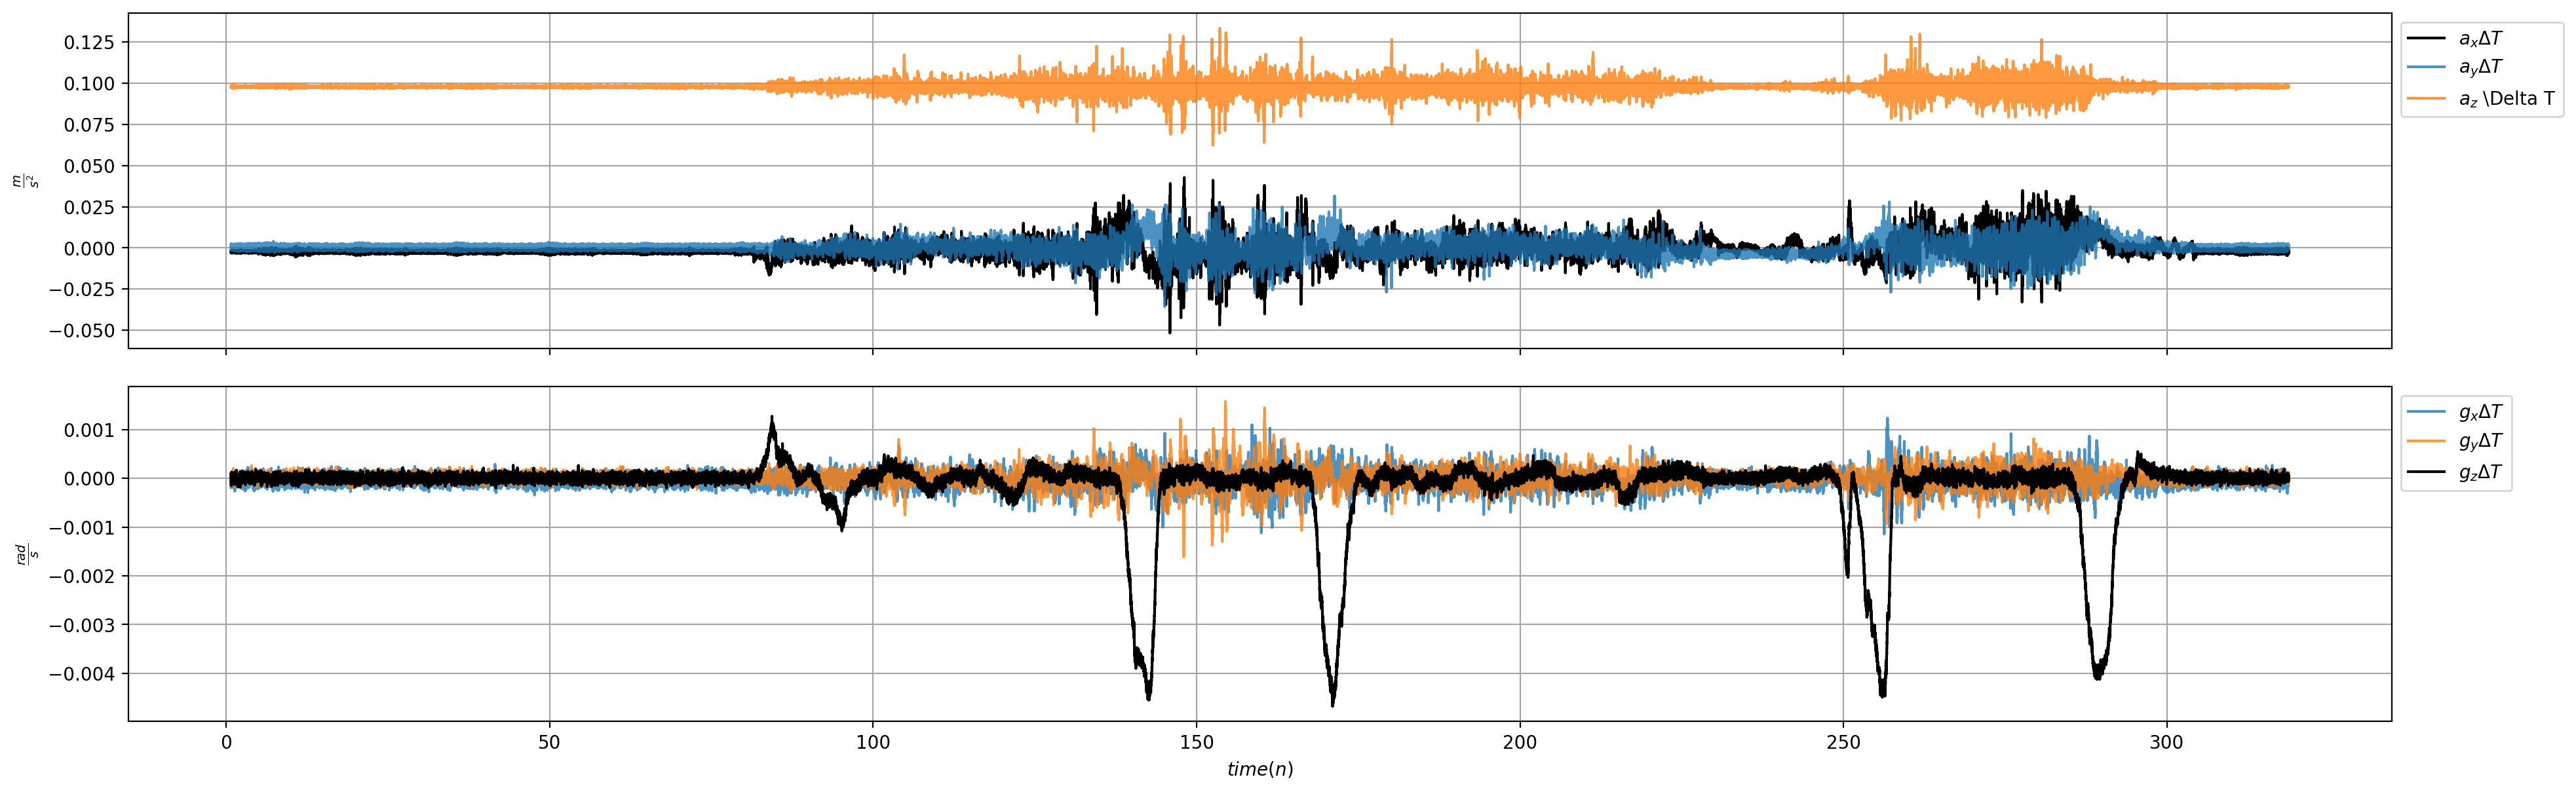

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,6),dpi=200, sharex='col')
fig.tight_layout()

ax1.plot(df_imu['t_rel'], df_imu['axdt'],  label=r'$a_x \Delta T$', color='k')
ax1.plot(df_imu['t_rel'], df_imu['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
ax1.plot(df_imu['t_rel'], df_imu['azdt'],  label=r'$a_z$ \Delta T', alpha=0.8)

ax1.legend(bbox_to_anchor=[1,1])
ax1.grid(True, which='both',ls='-',color='0.65')
ax1.set_ylabel(r'$\frac{m}{s^2}$')

ax2.plot(df_imu['t_rel'], df_imu['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
ax2.plot(df_imu['t_rel'], df_imu['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
ax2.plot(df_imu['t_rel'], df_imu['gzdt'],  label=r'$g_z \Delta T$', color='k')

ax2.legend(bbox_to_anchor=[1,1])
ax2.grid(True, which='both',ls='-',color='0.65')

ax2.set_xlabel(r'$time(n)$')
ax2.set_ylabel(r'$\frac{rad}{s}$')

In [24]:
# Keep a copy of gnss_index, this is for later join operations
df_gnss['gnss_index'] = df_gnss.index.to_numpy()
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index
0,1.547714e+09,1547714239,0.0,0.005091,0.003782,-0.004143,5.308365,22.330503,114.179537,16.316454,0.0,0
1,1.547714e+09,1547714240,0.0,0.004630,0.003031,-0.002556,5.309674,22.330503,114.179537,16.316684,1.0,1
2,1.547714e+09,1547714241,0.0,0.005245,0.001220,-0.003877,5.311706,22.330503,114.179537,16.316455,2.0,2
3,1.547714e+09,1547714242,0.0,0.001244,-0.001429,0.003159,5.312105,22.330503,114.179537,16.316016,3.0,3
4,1.547714e+09,1547714243,0.0,-0.001450,-0.000217,0.001732,5.312462,22.330503,114.179537,16.315405,4.0,4


In [25]:
_N_gnss = df_gnss.index.size
df_gnss['E'], df_gnss['N'], df_gnss['U'] = zip(*df_gnss.apply(
                                                        lambda x : pm.geodetic2enu(x['lat'], x['lon'], x['alt'],
                                                                                   df_gnss['lat'].iloc[int(_N_gnss/2)], df_gnss['lon'].iloc[int(_N_gnss/2)], df_gnss['alt'].iloc[int(_N_gnss/2)]
                                                                                   ), axis=1
))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


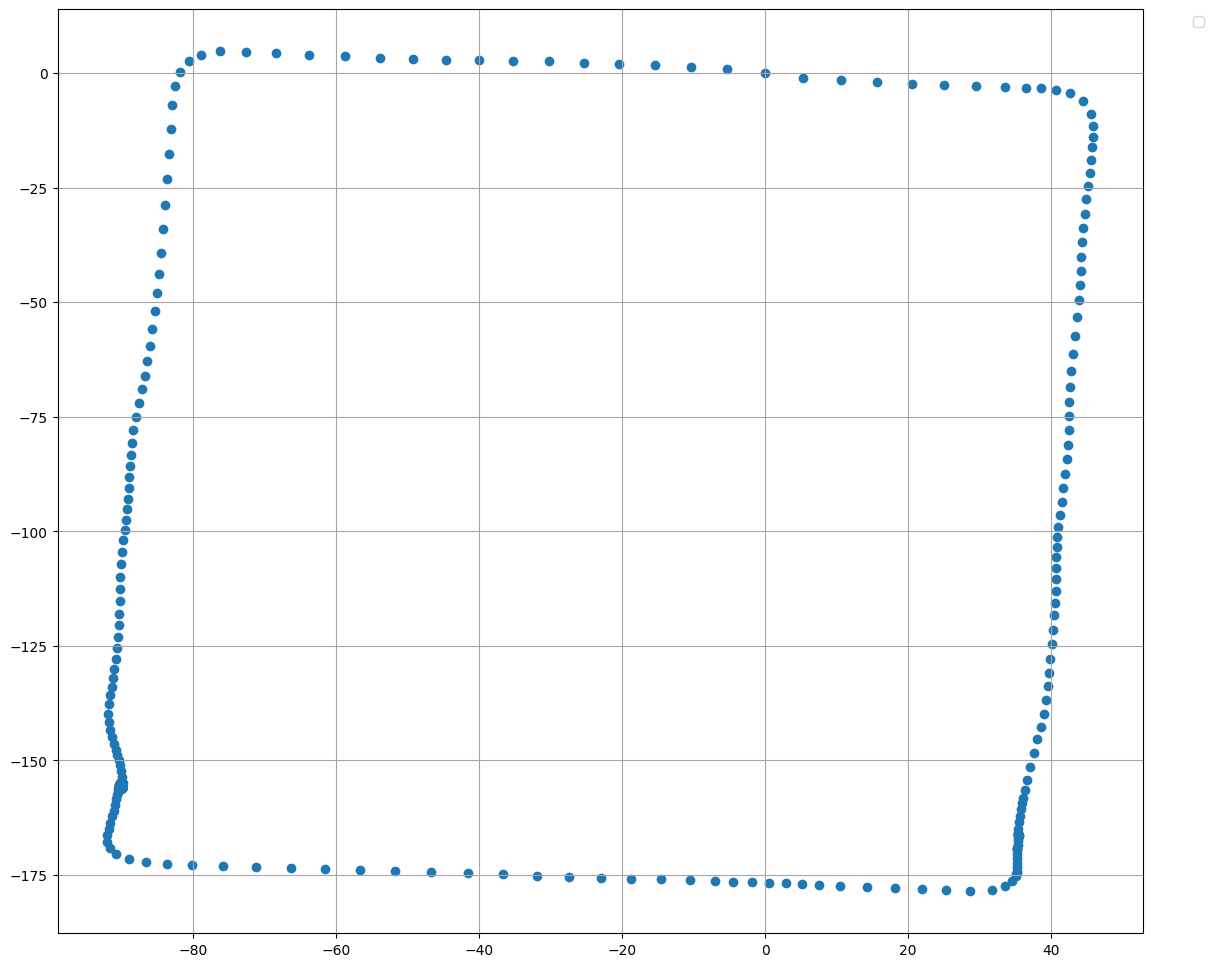

In [26]:
fig, ax = plt.subplots(figsize=(14,12))

ax.scatter(df_gnss['E'], df_gnss['N'])

ax.grid(True, which='both',ls='-',color='0.65')
ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')

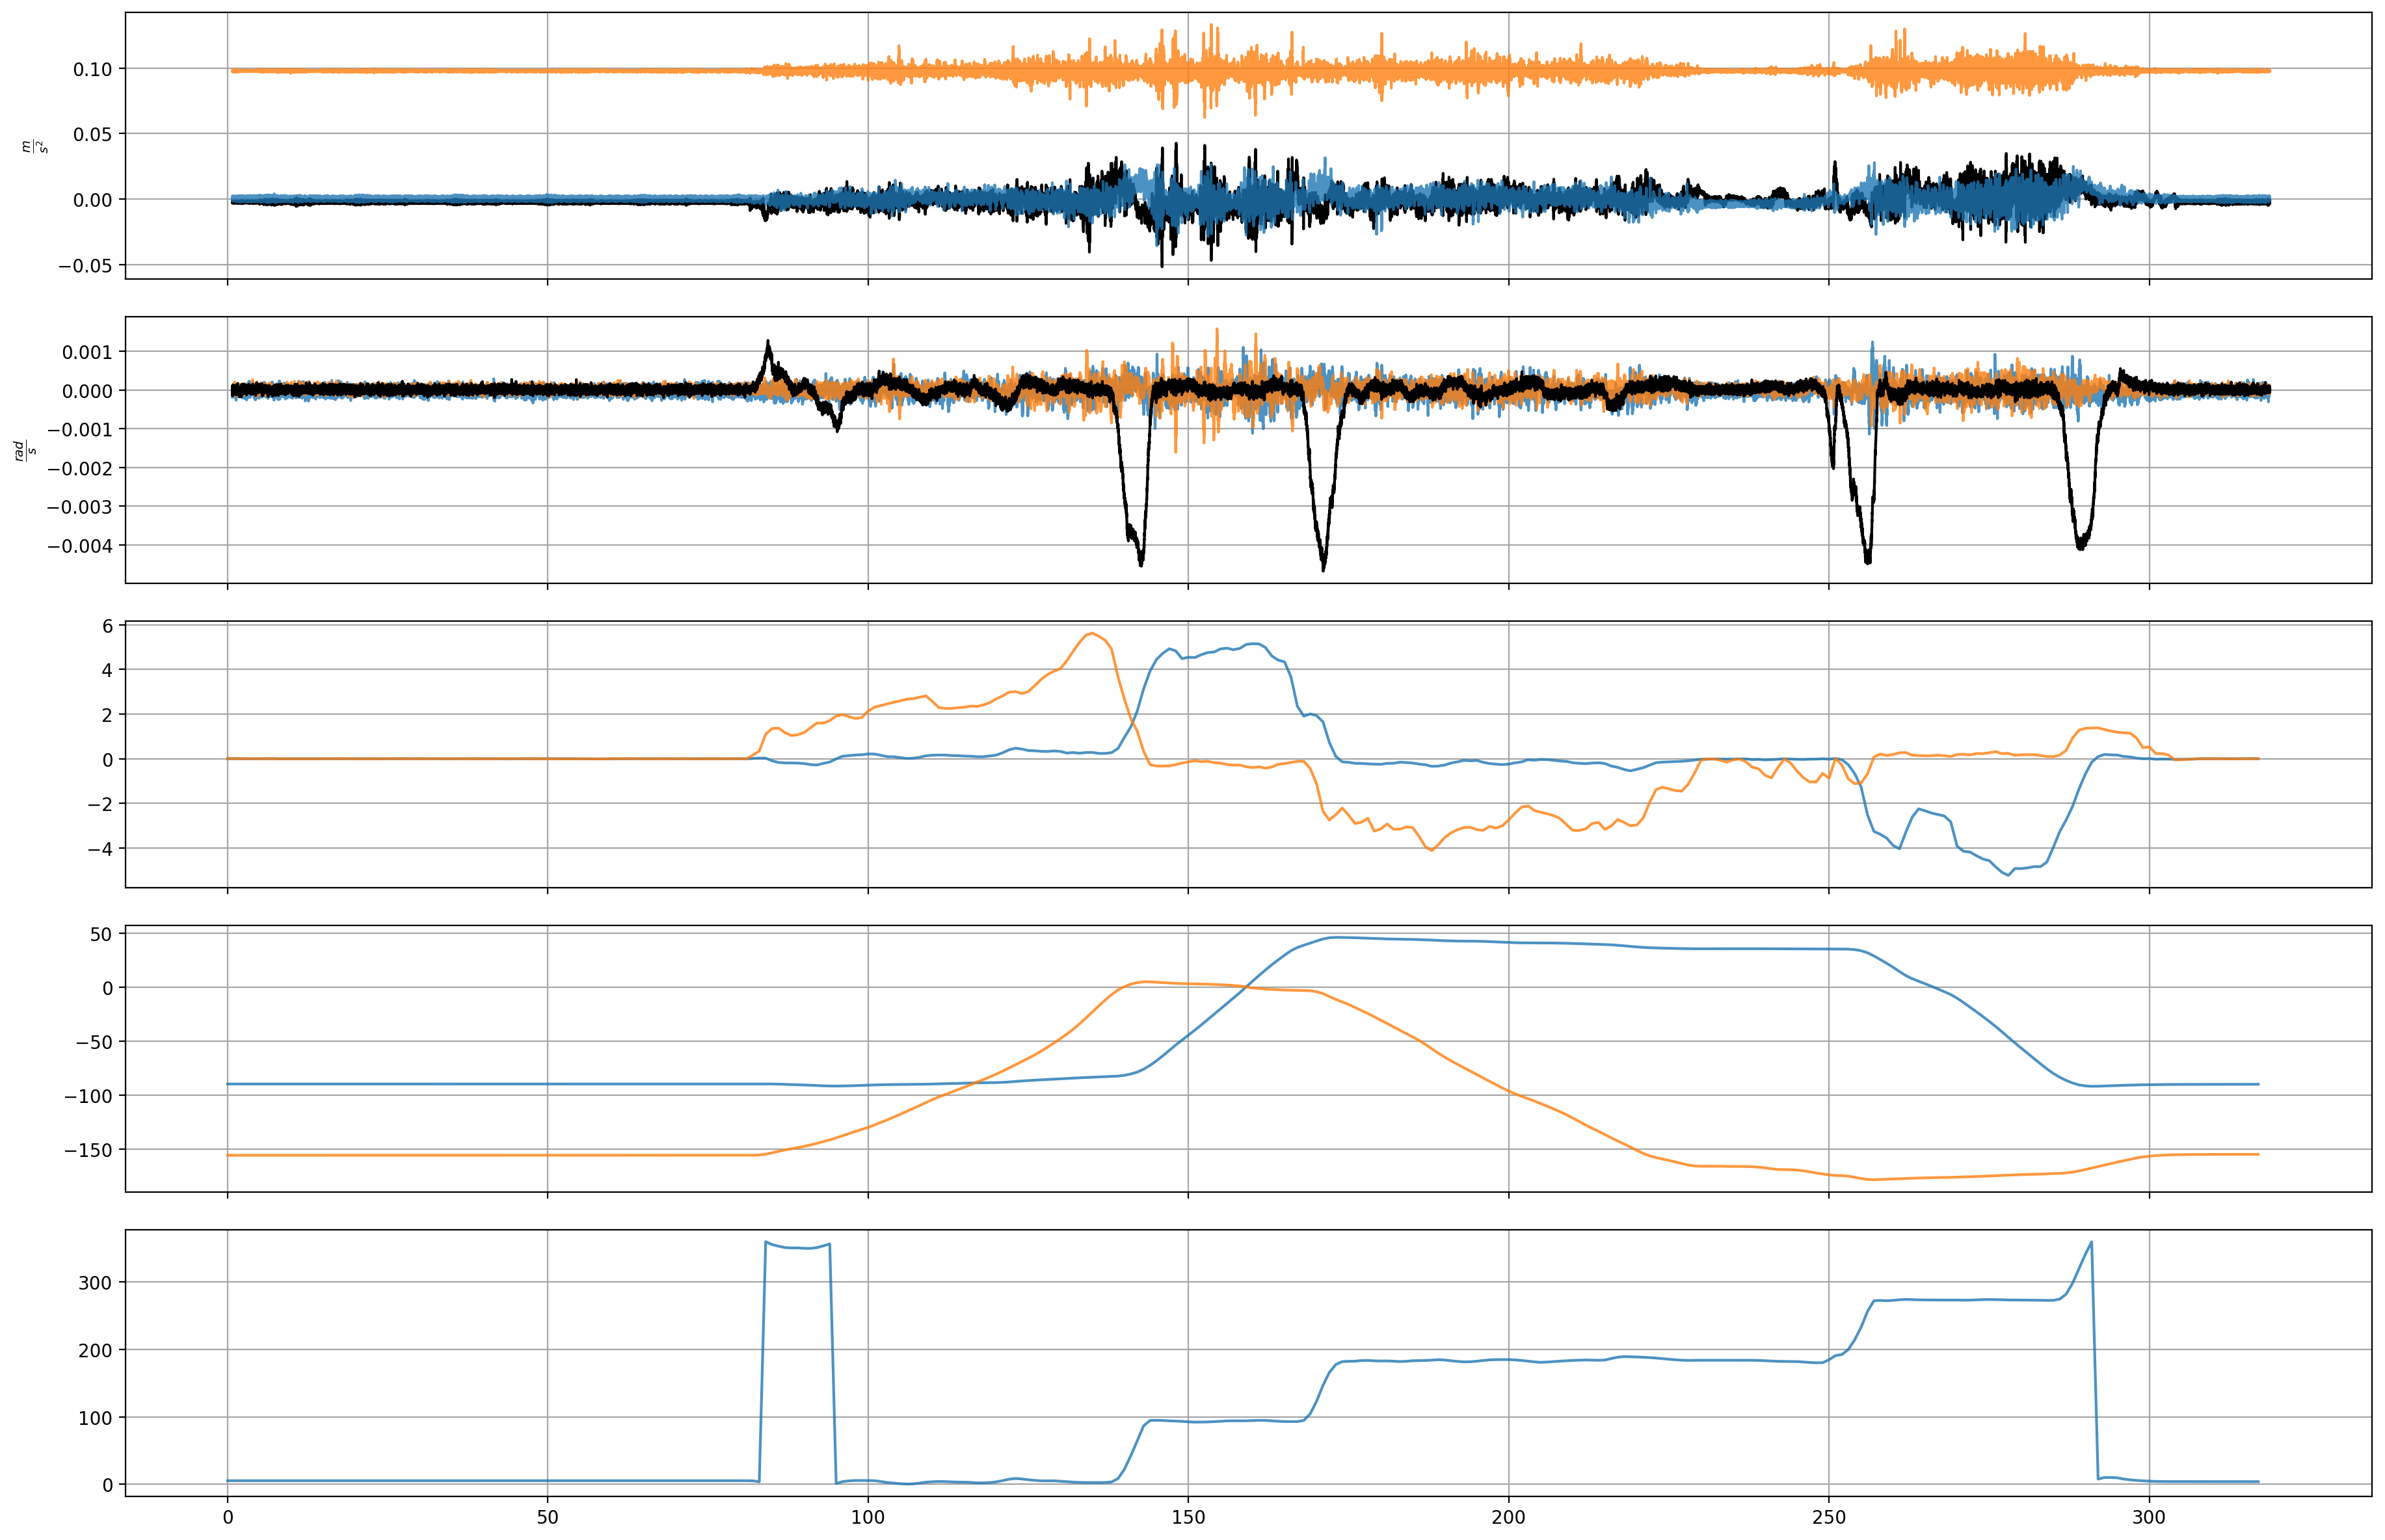

In [27]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(18,12),dpi=200, sharex='col')
fig.tight_layout()

axs[0].plot(df_imu['t_rel'], df_imu['axdt'],  label=r'$a_x \Delta T$', color='k')
axs[0].plot(df_imu['t_rel'], df_imu['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
axs[0].plot(df_imu['t_rel'],  df_imu['azdt'], label=r'$a_z \Delta T$', alpha=0.8)


axs[0].set_ylabel(r'$\frac{m}{s^2}$')

axs[1].plot(df_imu['t_rel'], df_imu['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
axs[1].plot(df_imu['t_rel'], df_imu['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
axs[1].plot(df_imu['t_rel'], df_imu['gzdt'],  label=r'$g_z \Delta T$', color='k')

axs[1].set_ylabel(r'$\frac{rad}{s}$')


axs[2].plot(df_gnss['t_rel'], df_gnss['ve'],  label=r'$Ve$', alpha=0.8)
axs[2].plot(df_gnss['t_rel'], df_gnss['vn'],  label=r'$Vn$', alpha=0.8)

axs[3].plot(df_gnss['t_rel'], df_gnss['E'],  label=r'$Ve$', alpha=0.8)
axs[3].plot(df_gnss['t_rel'], df_gnss['N'],  label=r'$Vn$', alpha=0.8)


axs[4].plot(df_gnss['t_rel'], df_gnss['azimuth'],  label=r'$Ve$', alpha=0.8)


for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')


Correlation between Velocity, and gyroscope, and accelerometer acitivity. Also some correlation between Azimuth and gyroscope data. Infact, accelerometer and gyroscope measure the cause of velocity changes and gyroscope measures cause of accelerometer change.

In [28]:
df_gnss['speed'] = np.sqrt(np.square(df_gnss['ve']) + np.square(df_gnss['vn']) + np.square(df_gnss['vu']))
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed
0,1.547714e+09,1547714239,0.0,0.005091,0.003782,-0.004143,5.308365,22.330503,114.179537,16.316454,0.0,0,-89.909776,-155.930420,-2.990607,0.007575
1,1.547714e+09,1547714240,0.0,0.004630,0.003031,-0.002556,5.309674,22.330503,114.179537,16.316684,1.0,1,-89.909447,-155.929734,-2.990377,0.006096
2,1.547714e+09,1547714241,0.0,0.005245,0.001220,-0.003877,5.311706,22.330503,114.179537,16.316455,2.0,2,-89.908854,-155.928912,-2.990606,0.006636
3,1.547714e+09,1547714242,0.0,0.001244,-0.001429,0.003159,5.312105,22.330503,114.179537,16.316016,3.0,3,-89.908273,-155.928208,-2.991045,0.003683
4,1.547714e+09,1547714243,0.0,-0.001450,-0.000217,0.001732,5.312462,22.330503,114.179537,16.315405,4.0,4,-89.907849,-155.927572,-2.991656,0.002269


In [29]:
df_gnss['speed_next'] = df_gnss['speed'].shift(-1)
df_gnss['azimuth_next'] = df_gnss['azimuth'].shift(-1)

In [30]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed,speed_next,azimuth_next
0,1.547714e+09,1547714239,0.0,0.005091,0.003782,-0.004143,5.308365,22.330503,114.179537,16.316454,0.0,0,-89.909776,-155.930420,-2.990607,0.007575,0.006096,5.309674
1,1.547714e+09,1547714240,0.0,0.004630,0.003031,-0.002556,5.309674,22.330503,114.179537,16.316684,1.0,1,-89.909447,-155.929734,-2.990377,0.006096,0.006636,5.311706
2,1.547714e+09,1547714241,0.0,0.005245,0.001220,-0.003877,5.311706,22.330503,114.179537,16.316455,2.0,2,-89.908854,-155.928912,-2.990606,0.006636,0.003683,5.312105
3,1.547714e+09,1547714242,0.0,0.001244,-0.001429,0.003159,5.312105,22.330503,114.179537,16.316016,3.0,3,-89.908273,-155.928208,-2.991045,0.003683,0.002269,5.312462
4,1.547714e+09,1547714243,0.0,-0.001450,-0.000217,0.001732,5.312462,22.330503,114.179537,16.315405,4.0,4,-89.907849,-155.927572,-2.991656,0.002269,0.005907,5.310712


In [31]:
df_gnss.tail(3)

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed,speed_next,azimuth_next
315,1.547715e+09,1547714554,0.0,0.003936,0.000068,0.006306,3.943163,22.330511,114.179535,16.245843,315.0,315,-90.172339,-155.045745,-3.061200,0.007434,0.006266,3.939580
316,1.547715e+09,1547714555,0.0,0.006131,-0.000510,0.001187,3.939580,22.330511,114.179535,16.246301,316.0,316,-90.166146,-155.039500,-3.060742,0.006266,0.004915,3.937139
317,1.547715e+09,1547714556,0.0,0.002080,-0.001430,0.004218,3.937139,22.330511,114.179535,16.246825,317.0,317,-90.160464,-155.034237,-3.060218,0.004915,NaN,NaN


In [32]:
df_gnss = df_gnss[df_gnss['speed_next'].notna()]

In [33]:
def classify_motion(row: pd.Series) -> tuple:
    speed = row['speed']
    speed_next = row['speed_next']

    if speed < 0.5 and speed_next < 0.5:
        return (1,0,0)
    else:
        azim = row['azimuth']
        azim_next = row['azimuth_next']
        if abs(azim - azim_next) < 2:
            return (0,1,0)
        return (0,0,1)       


In [34]:
df_gnss['rest'], df_gnss['straight'], df_gnss['turn'] = zip(*df_gnss.apply(lambda x: classify_motion(x), axis=1))

In [35]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.547714e+09,1547714239,0.0,0.005091,0.003782,-0.004143,5.308365,22.330503,114.179537,16.316454,...,0,-89.909776,-155.930420,-2.990607,0.007575,0.006096,5.309674,1,0,0
1,1.547714e+09,1547714240,0.0,0.004630,0.003031,-0.002556,5.309674,22.330503,114.179537,16.316684,...,1,-89.909447,-155.929734,-2.990377,0.006096,0.006636,5.311706,1,0,0
2,1.547714e+09,1547714241,0.0,0.005245,0.001220,-0.003877,5.311706,22.330503,114.179537,16.316455,...,2,-89.908854,-155.928912,-2.990606,0.006636,0.003683,5.312105,1,0,0
3,1.547714e+09,1547714242,0.0,0.001244,-0.001429,0.003159,5.312105,22.330503,114.179537,16.316016,...,3,-89.908273,-155.928208,-2.991045,0.003683,0.002269,5.312462,1,0,0
4,1.547714e+09,1547714243,0.0,-0.001450,-0.000217,0.001732,5.312462,22.330503,114.179537,16.315405,...,4,-89.907849,-155.927572,-2.991656,0.002269,0.005907,5.310712,1,0,0


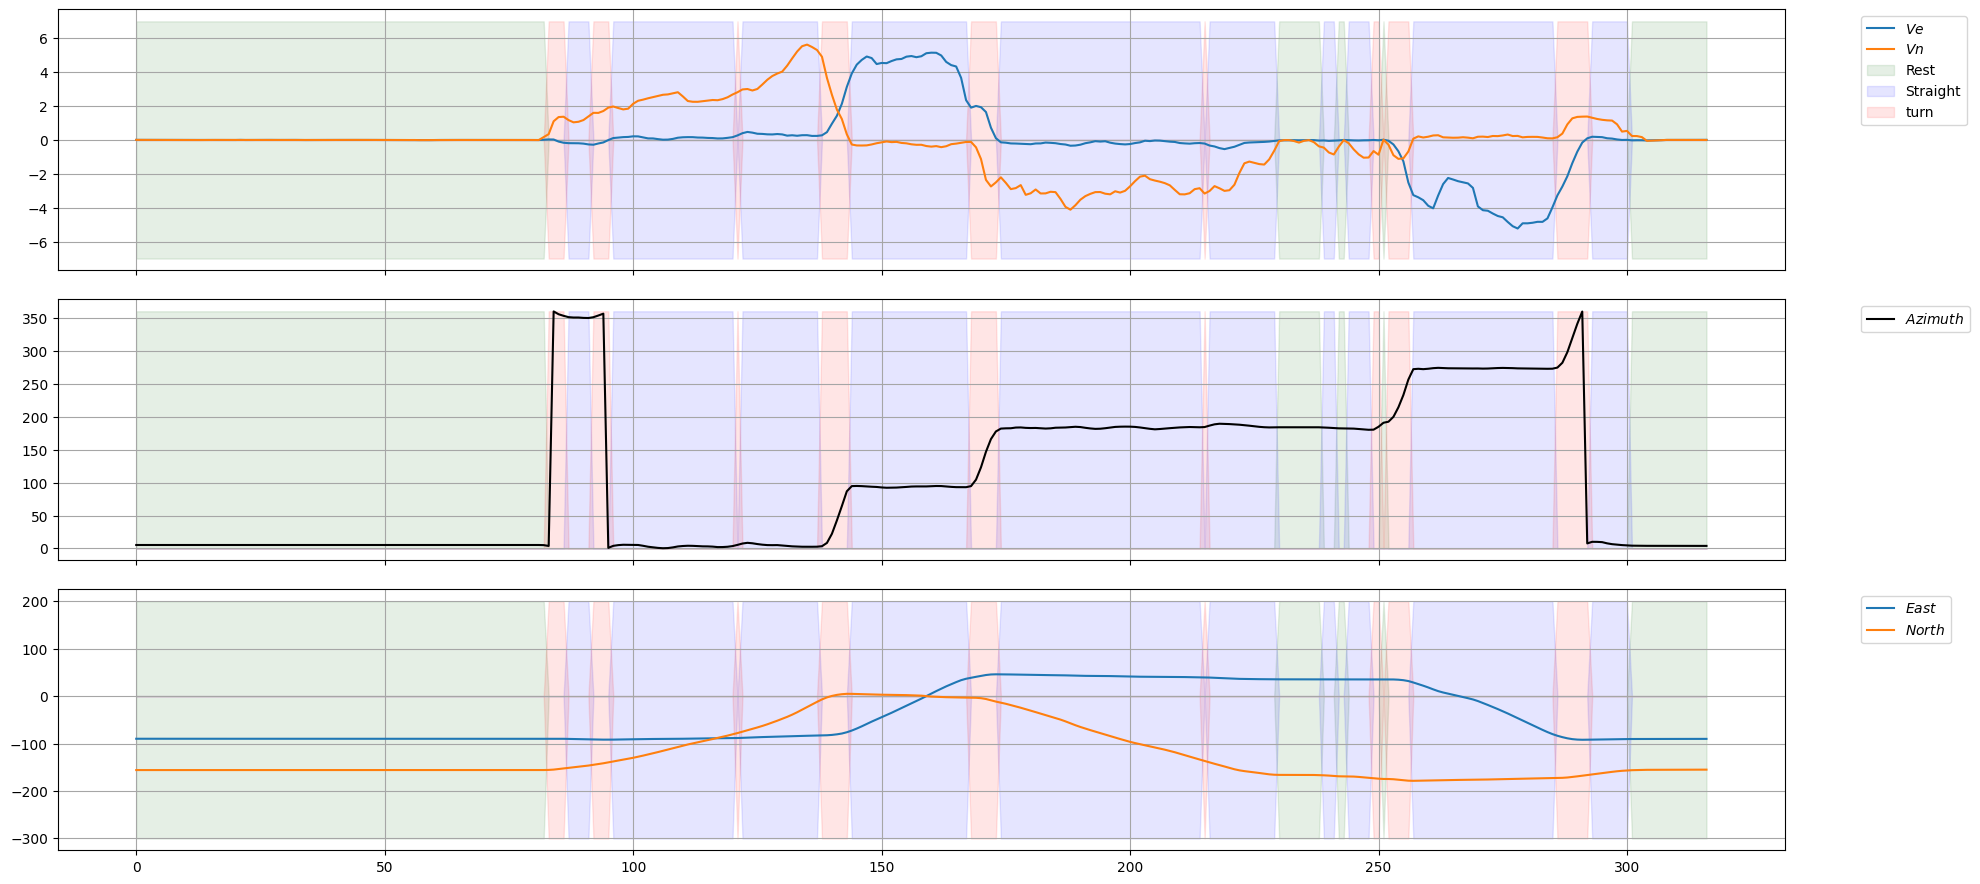

In [36]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18,9), sharex='col')
fig.tight_layout()


axs[0].plot(df_gnss['t_rel'], df_gnss['ve'],  label=r'$Ve$')
axs[0].plot(df_gnss['t_rel'], df_gnss['vn'],  label=r'$Vn$')

axs[0].fill_between(df_gnss['t_rel'],-7*df_gnss['rest'], 7*df_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[0].fill_between(df_gnss['t_rel'], -7*df_gnss['straight' ], 7*df_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[0].fill_between(df_gnss['t_rel'],-7*df_gnss['turn'], 7*df_gnss['turn'], color='red', alpha=0.1, label='turn')

axs[1].plot(df_gnss['t_rel'], df_gnss['azimuth'],  color='k', label=r'$Azimuth$')
axs[1].fill_between(df_gnss['t_rel'], 0*df_gnss['rest'], 360*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[1].fill_between(df_gnss['t_rel'], 0*df_gnss['straight'], 360*df_gnss['straight'], color='blue', alpha=0.1, )
axs[1].fill_between(df_gnss['t_rel'], 0*df_gnss['turn'], 360*df_gnss['turn'], color='red', alpha=0.1, )

axs[2].plot(df_gnss['t_rel'], df_gnss['E'],  label=r'$East$')
axs[2].plot(df_gnss['t_rel'], df_gnss['N'],  label=r'$North$')
axs[2].fill_between(df_gnss['t_rel'], -300*df_gnss['rest'], 200*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[2].fill_between(df_gnss['t_rel'], -300*df_gnss['straight'], 200*df_gnss['straight'], color='blue', alpha=0.1, )
axs[2].fill_between(df_gnss['t_rel'], -300*df_gnss['turn'], 200*df_gnss['turn'], color='red', alpha=0.1, )

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')
    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')

        

In [37]:
imu_gnss = pd.merge(df_imu, 
                    df_gnss,
                    how='left',
                    left_on='time_sec',
                    right_on='time_sec',
                    suffixes=['_imu', '_gnss'],)

The right side of the dataset (GNSS side) represents the last GNSS measurement right before the current IMU data

In [38]:
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.547714e+09,1547714239,744714975,-0.018890,0.006923,-0.013251,-0.001982,-0.001050,0.097584,0.744715,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
1,1.547714e+09,1547714239,754770040,-0.003317,-0.000612,0.011386,-0.003135,0.002541,0.097785,0.754770,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
2,1.547714e+09,1547714239,764771938,0.009405,-0.003641,-0.003362,-0.002669,0.001782,0.098563,0.764772,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
3,1.547714e+09,1547714239,774862051,-0.004492,-0.001124,-0.007554,-0.001420,-0.001095,0.097842,0.774862,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
4,1.547714e+09,1547714239,784799098,-0.005278,-0.005752,-0.007026,-0.002314,-0.001453,0.097841,0.784799,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0


In [39]:
imu_gnss = imu_gnss[imu_gnss['time_ns_gnss'].notna()]
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.547714e+09,1547714239,744714975,-0.018890,0.006923,-0.013251,-0.001982,-0.001050,0.097584,0.744715,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
1,1.547714e+09,1547714239,754770040,-0.003317,-0.000612,0.011386,-0.003135,0.002541,0.097785,0.754770,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
2,1.547714e+09,1547714239,764771938,0.009405,-0.003641,-0.003362,-0.002669,0.001782,0.098563,0.764772,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
3,1.547714e+09,1547714239,774862051,-0.004492,-0.001124,-0.007554,-0.001420,-0.001095,0.097842,0.774862,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
4,1.547714e+09,1547714239,784799098,-0.005278,-0.005752,-0.007026,-0.002314,-0.001453,0.097841,0.784799,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0


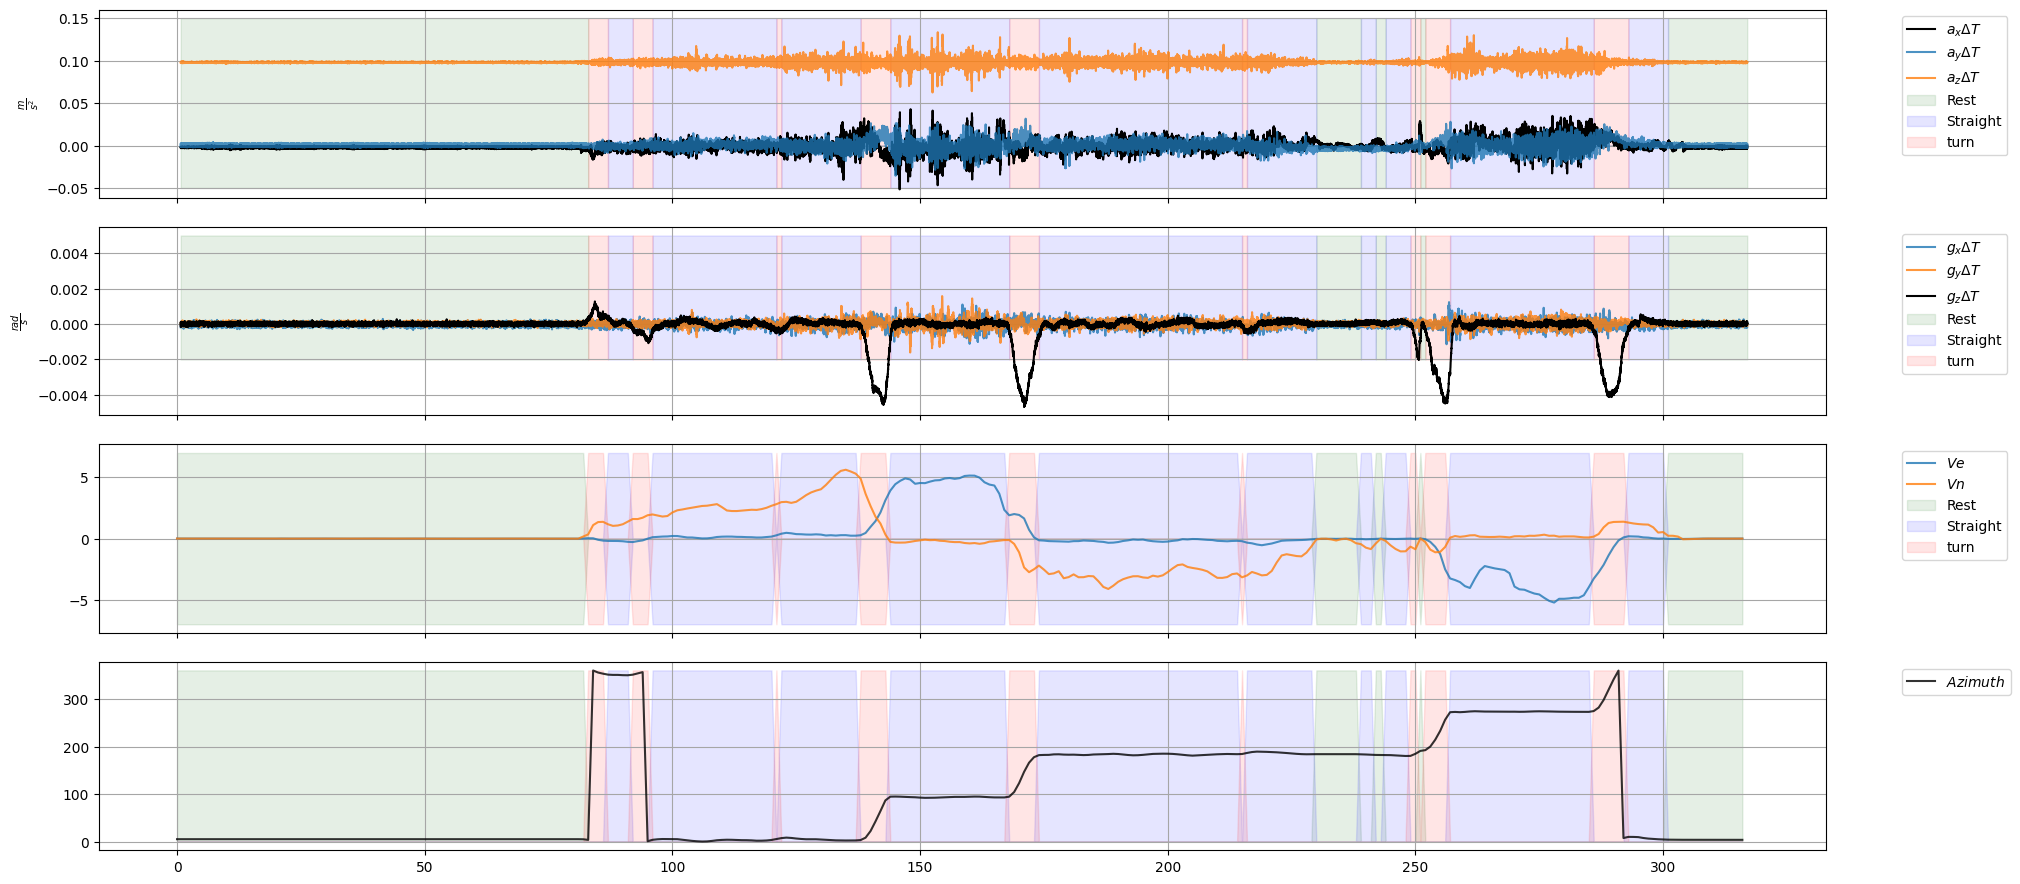

In [40]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18,9), sharex='col')
fig.tight_layout()

axs[0].plot(imu_gnss['t_rel_imu'], imu_gnss['axdt'],  label=r'$a_x \Delta T$', color='k')
axs[0].plot(imu_gnss['t_rel_imu'],imu_gnss['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
axs[0].plot(imu_gnss['t_rel_imu'], imu_gnss['azdt'], label=r'$a_z \Delta T$', alpha=0.8)
axs[0].fill_between(imu_gnss['t_rel_imu'],-5e-2*imu_gnss['rest'], 15e-2*imu_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[0].fill_between(imu_gnss['t_rel_imu'], -5e-2*imu_gnss['straight' ], 15e-2*imu_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[0].fill_between(imu_gnss['t_rel_imu'],-5e-2*imu_gnss['turn'],  15e-2*imu_gnss['turn'], color='red', alpha=0.1, label='turn')


axs[0].set_ylabel(r'$\frac{m}{s^2}$')

axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gzdt'],  label=r'$g_z \Delta T$', color='k')
axs[1].fill_between(imu_gnss['t_rel_imu'],-0.2e-2*imu_gnss['rest'], 0.5e-2*imu_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[1].fill_between(imu_gnss['t_rel_imu'], -0.2e-2*imu_gnss['straight' ], 0.5e-2*imu_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[1].fill_between(imu_gnss['t_rel_imu'],-0.2e-2*imu_gnss['turn'],  0.5e-2*imu_gnss['turn'], color='red', alpha=0.1, label='turn')
axs[1].set_ylabel(r'$\frac{rad}{s}$')


axs[2].plot(df_gnss['t_rel'], df_gnss['ve'],  label=r'$Ve$', alpha=0.8)
axs[2].plot(df_gnss['t_rel'], df_gnss['vn'],  label=r'$Vn$', alpha=0.8)
axs[2].fill_between(df_gnss['t_rel'],-7*df_gnss['rest'], 7*df_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[2].fill_between(df_gnss['t_rel'], -7*df_gnss['straight' ], 7*df_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[2].fill_between(df_gnss['t_rel'],-7*df_gnss['turn'], 7*df_gnss['turn'], color='red', alpha=0.1, label='turn')

axs[3].plot(df_gnss['t_rel'], df_gnss['azimuth'],  color='k', label=r'$Azimuth$', alpha=0.8)
axs[3].fill_between(df_gnss['t_rel'], 0*df_gnss['rest'], 360*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[3].fill_between(df_gnss['t_rel'], 0*df_gnss['straight'], 360*df_gnss['straight'], color='blue', alpha=0.1, )
axs[3].fill_between(df_gnss['t_rel'], 0*df_gnss['turn'], 360*df_gnss['turn'], color='red', alpha=0.1, )

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')
    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')

        

In [41]:
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az,t_rel,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
0,1.547714e+09,1547714239,744714975,-0.018890,0.006923,-0.013251,-0.001982,-0.001050,0.097584,0.744715,-0.001982,-0.001050,0.097584,-0.000189,0.000069,-0.000133,0.097610,0.000241
1,1.547714e+09,1547714239,754770040,-0.003317,-0.000612,0.011386,-0.003135,0.002541,0.097785,0.754770,-0.003135,0.002541,0.097785,-0.000033,-0.000006,0.000114,0.097868,0.000119
2,1.547714e+09,1547714239,764771938,0.009405,-0.003641,-0.003362,-0.002669,0.001782,0.098563,0.764772,-0.002669,0.001782,0.098563,0.000094,-0.000036,-0.000034,0.098616,0.000106
3,1.547714e+09,1547714239,774862051,-0.004492,-0.001124,-0.007554,-0.001420,-0.001095,0.097842,0.774862,-0.001420,-0.001095,0.097842,-0.000045,-0.000011,-0.000076,0.097859,0.000089
4,1.547714e+09,1547714239,784799098,-0.005278,-0.005752,-0.007026,-0.002314,-0.001453,0.097841,0.784799,-0.002314,-0.001453,0.097841,-0.000053,-0.000058,-0.000070,0.097879,0.000105


In [42]:
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.547714e+09,1547714239,744714975,-0.018890,0.006923,-0.013251,-0.001982,-0.001050,0.097584,0.744715,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
1,1.547714e+09,1547714239,754770040,-0.003317,-0.000612,0.011386,-0.003135,0.002541,0.097785,0.754770,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
2,1.547714e+09,1547714239,764771938,0.009405,-0.003641,-0.003362,-0.002669,0.001782,0.098563,0.764772,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
3,1.547714e+09,1547714239,774862051,-0.004492,-0.001124,-0.007554,-0.001420,-0.001095,0.097842,0.774862,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0
4,1.547714e+09,1547714239,784799098,-0.005278,-0.005752,-0.007026,-0.002314,-0.001453,0.097841,0.784799,...,0.0,-89.909776,-155.93042,-2.990607,0.007575,0.006096,5.309674,1.0,0.0,0.0


In [43]:
imu_window_sum = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].sum()
imu_window_sum.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,-0.058822,0.010874,2.544976,-0.000967,0.000823,-0.000210,2.545991,0.003137
1.0,-0.223018,0.039943,9.788119,-0.003140,0.000351,-0.000049,9.791828,0.011956
2.0,-0.222522,0.035317,9.788194,-0.002686,0.002897,0.000795,9.791926,0.012479
3.0,-0.223304,0.041123,9.789213,-0.003405,0.002062,0.000181,9.793009,0.011842
4.0,-0.224027,0.038616,9.787893,-0.003020,0.001808,0.001529,9.791697,0.011758


In [44]:
imu_window_var = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].var()
imu_window_var.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,2.620811e-07,0.000002,2.229108e-07,5.920816e-09,3.321791e-09,5.625258e-09,2.209511e-07,2.283056e-09
1.0,2.337172e-07,0.000002,1.875037e-07,7.127246e-09,4.748617e-09,4.005550e-09,1.906057e-07,2.450247e-09
2.0,2.776219e-07,0.000002,9.885091e-08,8.415966e-09,3.900123e-09,4.623897e-09,9.991127e-08,2.849623e-09
3.0,2.813144e-07,0.000002,8.021861e-08,8.668215e-09,3.261839e-09,3.373985e-09,8.170654e-08,2.743603e-09
4.0,3.282090e-07,0.000002,1.095458e-07,6.701061e-09,4.993413e-09,4.006629e-09,1.070334e-07,3.224875e-09


In [45]:
imu_window_min = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].min()
imu_window_min.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,-0.003135,-0.001453,0.096956,-0.000189,-0.000058,-0.000149,0.096978,0.000040
1.0,-0.003256,-0.002003,0.096738,-0.000267,-0.000154,-0.000177,0.096799,0.000039
2.0,-0.003437,-0.002204,0.097124,-0.000258,-0.000135,-0.000183,0.097155,0.000027
3.0,-0.003270,-0.002102,0.097229,-0.000205,-0.000094,-0.000110,0.097284,0.000012
4.0,-0.003462,-0.001887,0.097264,-0.000256,-0.000173,-0.000142,0.097299,0.000008


In [46]:
imu_window_max = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].max()
imu_window_max.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,-0.001420,0.002541,0.098795,0.000127,0.000157,0.000133,0.098823,0.000241
1.0,-0.001208,0.002700,0.099038,0.000152,0.000207,0.000170,0.099082,0.000271
2.0,-0.001114,0.002727,0.098660,0.000165,0.000156,0.000146,0.098707,0.000302
3.0,-0.001325,0.002821,0.098730,0.000228,0.000264,0.000145,0.098749,0.000275
4.0,-0.000800,0.002858,0.099018,0.000156,0.000211,0.000188,0.099036,0.000269


In [47]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.547714e+09,1547714239,0.0,0.005091,0.003782,-0.004143,5.308365,22.330503,114.179537,16.316454,...,0,-89.909776,-155.930420,-2.990607,0.007575,0.006096,5.309674,1,0,0
1,1.547714e+09,1547714240,0.0,0.004630,0.003031,-0.002556,5.309674,22.330503,114.179537,16.316684,...,1,-89.909447,-155.929734,-2.990377,0.006096,0.006636,5.311706,1,0,0
2,1.547714e+09,1547714241,0.0,0.005245,0.001220,-0.003877,5.311706,22.330503,114.179537,16.316455,...,2,-89.908854,-155.928912,-2.990606,0.006636,0.003683,5.312105,1,0,0
3,1.547714e+09,1547714242,0.0,0.001244,-0.001429,0.003159,5.312105,22.330503,114.179537,16.316016,...,3,-89.908273,-155.928208,-2.991045,0.003683,0.002269,5.312462,1,0,0
4,1.547714e+09,1547714243,0.0,-0.001450,-0.000217,0.001732,5.312462,22.330503,114.179537,16.315405,...,4,-89.907849,-155.927572,-2.991656,0.002269,0.005907,5.310712,1,0,0


In [48]:
df_labels = df_gnss[['time','time_sec', 'time_ns', 'gnss_index', 'rest', 'straight','turn']].copy()
df_labels.head()

,time,time_sec,time_ns,gnss_index,rest,straight,turn
0,1.547714e+09,1547714239,0.0,0,1,0,0
1,1.547714e+09,1547714240,0.0,1,1,0,0
2,1.547714e+09,1547714241,0.0,2,1,0,0
3,1.547714e+09,1547714242,0.0,3,1,0,0
4,1.547714e+09,1547714243,0.0,4,1,0,0


In [49]:
# Add the features to the labels dataset
res_to_sffx = {
        '_sum': imu_window_sum,
        '_var': imu_window_var,
        '_min': imu_window_min,
        '_max': imu_window_max,
}
for key, _df in res_to_sffx.items():
    df_labels = pd.merge(
                left=df_labels,
                right=_df,
                left_on ='gnss_index',
                right_on='gnss_index',
                suffixes=[None, key]
    )

In [50]:
df_labels.head()

,time,time_sec,time_ns,gnss_index,rest,straight,turn,axdt,aydt,azdt,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,1.547714e+09,1547714239,0.0,0,1,0,0,-0.058822,0.010874,2.544976,...,0.096978,0.000040,-0.001420,0.002541,0.098795,0.000127,0.000157,0.000133,0.098823,0.000241
1,1.547714e+09,1547714240,0.0,1,1,0,0,-0.223018,0.039943,9.788119,...,0.096799,0.000039,-0.001208,0.002700,0.099038,0.000152,0.000207,0.000170,0.099082,0.000271
2,1.547714e+09,1547714241,0.0,2,1,0,0,-0.222522,0.035317,9.788194,...,0.097155,0.000027,-0.001114,0.002727,0.098660,0.000165,0.000156,0.000146,0.098707,0.000302
3,1.547714e+09,1547714242,0.0,3,1,0,0,-0.223304,0.041123,9.789213,...,0.097284,0.000012,-0.001325,0.002821,0.098730,0.000228,0.000264,0.000145,0.098749,0.000275
4,1.547714e+09,1547714243,0.0,4,1,0,0,-0.224027,0.038616,9.787893,...,0.097299,0.000008,-0.000800,0.002858,0.099018,0.000156,0.000211,0.000188,0.099036,0.000269


In [51]:
df_labels['gnss_index_start'] = df_labels['gnss_index'].copy()
df_labels['gnss_index_end'] = df_labels['gnss_index_start'] + 1

In [52]:
df_labels.head()

,time,time_sec,time_ns,gnss_index,rest,straight,turn,axdt,aydt,azdt,...,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max,gnss_index_start,gnss_index_end
0,1.547714e+09,1547714239,0.0,0,1,0,0,-0.058822,0.010874,2.544976,...,-0.001420,0.002541,0.098795,0.000127,0.000157,0.000133,0.098823,0.000241,0,1
1,1.547714e+09,1547714240,0.0,1,1,0,0,-0.223018,0.039943,9.788119,...,-0.001208,0.002700,0.099038,0.000152,0.000207,0.000170,0.099082,0.000271,1,2
2,1.547714e+09,1547714241,0.0,2,1,0,0,-0.222522,0.035317,9.788194,...,-0.001114,0.002727,0.098660,0.000165,0.000156,0.000146,0.098707,0.000302,2,3
3,1.547714e+09,1547714242,0.0,3,1,0,0,-0.223304,0.041123,9.789213,...,-0.001325,0.002821,0.098730,0.000228,0.000264,0.000145,0.098749,0.000275,3,4
4,1.547714e+09,1547714243,0.0,4,1,0,0,-0.224027,0.038616,9.787893,...,-0.000800,0.002858,0.099018,0.000156,0.000211,0.000188,0.099036,0.000269,4,5


In [53]:
rename_map = {}
for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'a', 'g']:
    rename_map[col+'dt'] = col+'dt_sum'
rename_map

{'axdt': 'axdt_sum',
 'aydt': 'aydt_sum',
 'azdt': 'azdt_sum',
 'gxdt': 'gxdt_sum',
 'gydt': 'gydt_sum',
 'gzdt': 'gzdt_sum',
 'adt': 'adt_sum',
 'gdt': 'gdt_sum'}

In [54]:
df_results = df_labels.rename(rename_map, axis=1).copy()

In [55]:
df_results.head()

,time,time_sec,time_ns,gnss_index,rest,straight,turn,axdt_sum,aydt_sum,azdt_sum,...,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max,gnss_index_start,gnss_index_end
0,1.547714e+09,1547714239,0.0,0,1,0,0,-0.058822,0.010874,2.544976,...,-0.001420,0.002541,0.098795,0.000127,0.000157,0.000133,0.098823,0.000241,0,1
1,1.547714e+09,1547714240,0.0,1,1,0,0,-0.223018,0.039943,9.788119,...,-0.001208,0.002700,0.099038,0.000152,0.000207,0.000170,0.099082,0.000271,1,2
2,1.547714e+09,1547714241,0.0,2,1,0,0,-0.222522,0.035317,9.788194,...,-0.001114,0.002727,0.098660,0.000165,0.000156,0.000146,0.098707,0.000302,2,3
3,1.547714e+09,1547714242,0.0,3,1,0,0,-0.223304,0.041123,9.789213,...,-0.001325,0.002821,0.098730,0.000228,0.000264,0.000145,0.098749,0.000275,3,4
4,1.547714e+09,1547714243,0.0,4,1,0,0,-0.224027,0.038616,9.787893,...,-0.000800,0.002858,0.099018,0.000156,0.000211,0.000188,0.099036,0.000269,4,5


In [56]:
def motion_state_str(row: pd.Series) -> str:
    if row['rest']:
        return 'rest'
    if row['straight']:
        return 'straight'
    if row['turn']:
        return 'turn'

In [57]:
df_results['motion_state'] = df_results.apply(lambda x: motion_state_str(x), axis=1)

In [58]:
feature_target_cols = 'motion_state,axdt_sum,aydt_sum,azdt_sum,gxdt_sum,gydt_sum,gzdt_sum,adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,axdt_min,aydt_min,azdt_min,gxdt_min,gydt_min,gzdt_min,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max'.split(',')
feature_target_cols 

['motion_state',
 'axdt_sum',
 'aydt_sum',
 'azdt_sum',
 'gxdt_sum',
 'gydt_sum',
 'gzdt_sum',
 'adt_sum',
 'gdt_sum',
 'axdt_var',
 'aydt_var',
 'azdt_var',
 'gxdt_var',
 'gydt_var',
 'gzdt_var',
 'adt_var',
 'gdt_var',
 'axdt_min',
 'aydt_min',
 'azdt_min',
 'gxdt_min',
 'gydt_min',
 'gzdt_min',
 'adt_min',
 'gdt_min',
 'axdt_max',
 'aydt_max',
 'azdt_max',
 'gxdt_max',
 'gydt_max',
 'gzdt_max',
 'adt_max',
 'gdt_max']

In [59]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              317 non-null    float64
 1   time_sec          317 non-null    int64  
 2   time_ns           317 non-null    float64
 3   gnss_index        317 non-null    int64  
 4   rest              317 non-null    int64  
 5   straight          317 non-null    int64  
 6   turn              317 non-null    int64  
 7   axdt_sum          317 non-null    float64
 8   aydt_sum          317 non-null    float64
 9   azdt_sum          317 non-null    float64
 10  gxdt_sum          317 non-null    float64
 11  gydt_sum          317 non-null    float64
 12  gzdt_sum          317 non-null    float64
 13  adt_sum           317 non-null    float64
 14  gdt_sum           317 non-null    float64
 15  axdt_var          317 non-null    float64
 16  aydt_var          317 non-null    float64
 1

In [60]:
df_results[feature_target_cols].to_csv('data/testing2.csv', index=False)